In [1]:
# 回到 FINRL/
%cd ..

/Users/shrshiunhuang/Documents/Project/FinRL


In [2]:
from AI_Trading.src import config
from AI_Trading.src.env_portfolio_allocation import *
from AI_Trading.src.evaluate import *
from AI_Trading.src import model_config
from AI_Trading.src.preprocess import *
from AI_Trading.src.testPortfolio import *
from AI_Trading.src.train import *
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
import pandas as pd
from warnings import simplefilter
simplefilter(action='ignore')
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

/Users/shrshiunhuang/Documents/Project/FinRL/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# data preprocess
train,trade = preprocess(config.TRAIN_START_DATE_0, config.TRAIN_END_DATE_0, config.TEST_START_DATE_0, config.TEST_END_DATE_0)


In [4]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": config.INITIAL_AMOUNT, 
        "transaction_cost_pct": 0.001, 
        "state_space": len(train.tic.unique()), 
        "stock_dim": len(train.tic.unique()), 
        "tech_indicator_list": config.INDICATORS, 
        "action_space": len(train.tic.unique()), 
        "reward_scaling": 1e-4,
    }

env_train = portfolioAllocationEnv(df = train, **env_kwargs)


env_trade = portfolioAllocationEnv(df = trade, **env_kwargs)

In [5]:
# train
model_index = 0
model_name = 'A2C'
trainPortfolioAllocation(env_train, model_name, model_index)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to ./AI_Trading/tensorboard//a2c/a2c_16
-------------------------------------
| time/                 |           |
|    fps                | 1377      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -4.23     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 1.08e+07  |
|    reward             | 1070654.9 |
|    std                | 0.991     |
|    value_loss         | 1.21e+13  |
-------------------------------------


In [6]:
# load model
model_zip_path = config.TRAINED_MODEL_PATH + model_name + '_' + str(model_index) + '.zip'
if model_name == 'A2C':
    model = A2C.load(model_zip_path)
elif model_name == 'PPO':
    model = PPO.load(model_zip_path)
elif model_name == 'DDPG':
    model = DDPG.load(model_zip_path)
elif model_name == 'TD3':
    model = TD3.load(model_zip_path)
elif model_name == 'SAC':
    model = SAC.load(model_zip_path)

In [7]:
# test
df_daily_return, df_actions = test_portfolioAllocation(model, env_trade)
df_daily_return.to_csv(config.RESULTS_DIR + 'df_daily_return')
df_actions.to_csv(config.RESULTS_DIR + 'df_actions')

begin_total_asset:1000000
end_total_asset:1057771.8387417872
Sharpe:  0.34995048175292975
hit end!


In [8]:
# evaluate
print("==============DRL Strategy Stats===========")
DRL_start, DRL_stats = getDRLStats(df_daily_return)
DRL_stats

==============DRL Strategy Stats===========


Annual return          0.057772
Cumulative returns     0.057772
Annual volatility      0.249935
Sharpe ratio           0.349950
Calmar ratio           0.191026
Stability              0.188260
Max drawdown          -0.302430
Omega ratio            1.073402
Sortino ratio          0.478299
Skew                  -0.483101
Kurtosis               7.161003
Tail ratio             1.002012
Daily value at risk   -0.031142
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [9]:
print("==============Equal Weight Strategy Stats===========")
equalWeight_returns, equalWeight_stats = getEqualWeightStats(trade)

==============Equal Weight Strategy Stats===========
Annual return          0.105870
Cumulative returns     0.105870
Annual volatility      0.183684
Sharpe ratio           0.642723
Calmar ratio           0.483449
Stability              0.416777
Max drawdown          -0.218989
Omega ratio            1.138319
Sortino ratio          0.826259
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.984563
Daily value at risk   -0.022674
dtype: float64


In [10]:
print("==============Min-Variance Strategy Stats===========")
minVariance, minVariance_stats = getMinVariance(trade)
minVariance_stats

==============Min-Variance Strategy Stats===========


Annual return          0.199871
Cumulative returns     0.199871
Annual volatility      0.141080
Sharpe ratio           1.367860
Calmar ratio           1.431956
Stability              0.820705
Max drawdown          -0.139579
Omega ratio            1.298046
Sortino ratio          1.900810
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.202535
Daily value at risk   -0.017009
Alpha                  0.000000
Beta                   1.000000
dtype: float64

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,5.777%
Cumulative returns,5.777%
Annual volatility,24.994%
Sharpe ratio,0.35
Calmar ratio,0.19
Stability,0.19
Max drawdown,-30.243%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.24,2020-02-14,2020-03-23,2020-12-15,218
1,1.24,2020-01-23,2020-01-31,2020-02-06,11
2,1.08,2020-12-17,2020-12-29,NaT,NaN
3,0.60,2020-01-03,2020-01-07,2020-01-10,6
4,0.30,2020-01-21,2020-01-22,2020-01-23,3


Stress Events,mean,min,max
New Normal,0.03%,-7.73%,7.52%


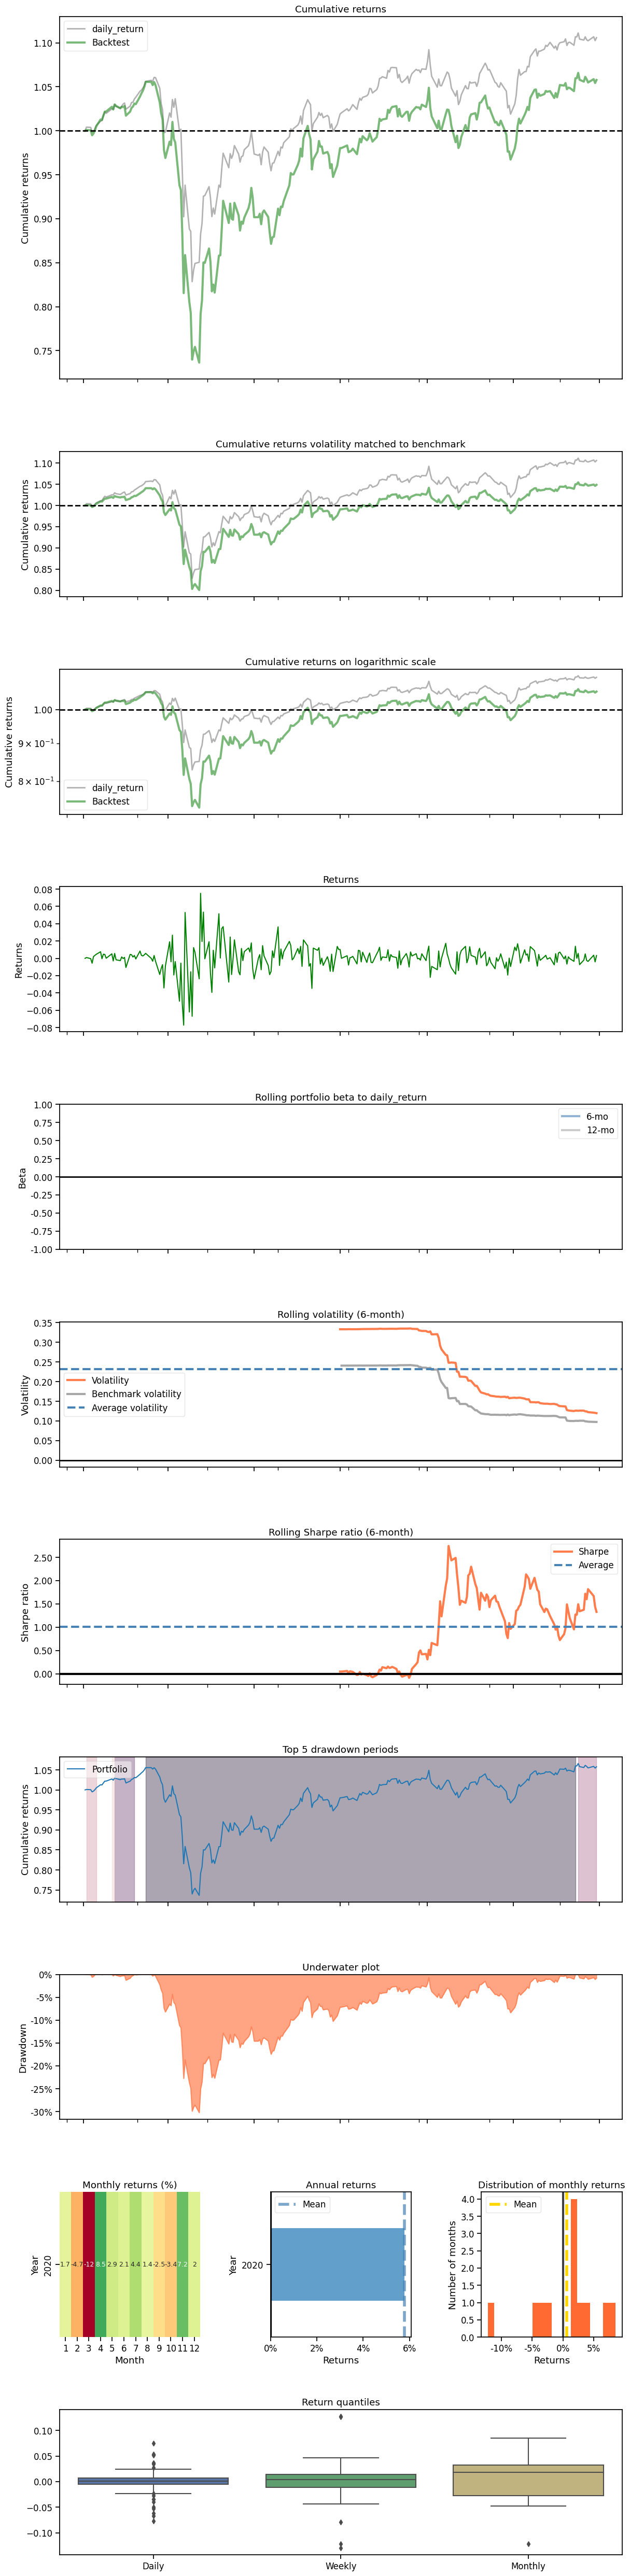

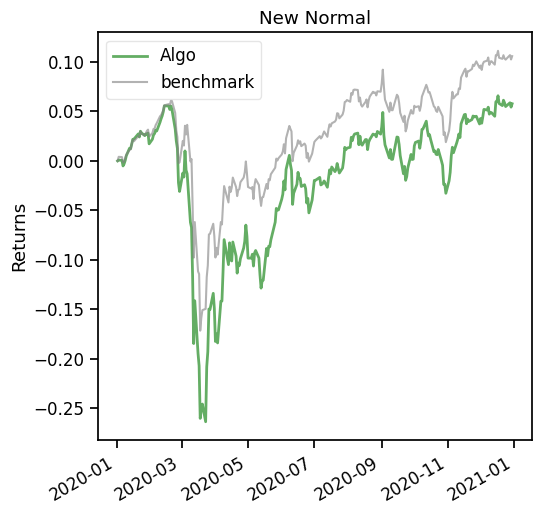

In [11]:
backtestPlot(DRL_start, equalWeight_returns)

In [12]:
print("==============All In Stock Strategy Stats===========")
all_stock, stock_stats = getSingleStats(trade, 'VTI')

==============All In Stock Strategy Stats===========
Annual return          0.174385
Cumulative returns     0.174385
Annual volatility      0.342913
Sharpe ratio           0.643331
Calmar ratio           0.498238
Stability              0.417230
Max drawdown          -0.350003
Omega ratio            1.137599
Sortino ratio          0.876570
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.874110
Daily value at risk   -0.042328
dtype: float64


In [13]:
print("==============All In Debt Strategy Stats===========")
all_debt, debt_stats = getSingleStats(trade, 'TLT')

==============All In Debt Strategy Stats===========
Annual return          0.149551
Cumulative returns     0.149551
Annual volatility      0.216263
Sharpe ratio           0.754591
Calmar ratio           0.950877
Stability              0.170797
Max drawdown          -0.157277
Omega ratio            1.158568
Sortino ratio          1.137780
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.057718
Daily value at risk   -0.026599
dtype: float64


In [14]:
print("==============All In Reit Strategy Stats===========")
all_reit, reit_stats = getSingleStats(trade, 'VNQ')

==============All In Reit Strategy Stats===========
Annual return         -0.082661
Cumulative returns    -0.082661
Annual volatility      0.419540
Sharpe ratio           0.008097
Calmar ratio          -0.192933
Stability              0.010442
Max drawdown          -0.428442
Omega ratio            1.001621
Sortino ratio          0.010640
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953195
Daily value at risk   -0.052844
dtype: float64


In [15]:
cumulativeReturnPlot(df_daily_return, minVariance, equalWeight_returns, all_stock, all_debt, all_reit)

In [16]:
myReturns = computeReturns(df_actions, trade)

In [17]:

df_VTI = load_data('./AI_Trading/data/VTI.csv', 'VTI')
df_VNQ = load_data('./AI_Trading/data/VNQ.csv', 'VNQ')
df_TLT = load_data('./AI_Trading/data/TLT.csv', 'TLT')

In [18]:
print("==============All In Stock Strategy Stats===========")
all_stock, stock_stats = getSingleStats(df_VTI, 'VTI')

==============All In Stock Strategy Stats===========
Annual return          0.062270
Cumulative returns     2.593461
Annual volatility      0.195538
Sharpe ratio           0.406981
Calmar ratio           0.109914
Stability              0.861152
Max drawdown          -0.566532
Omega ratio            1.080927
Sortino ratio          0.568243
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.922777
Daily value at risk   -0.024320
dtype: float64


In [19]:
print("==============All In Debt Strategy Stats===========")
all_debt, debt_stats = getSingleStats(df_TLT, 'TLT')

==============All In Debt Strategy Stats===========
Annual return          0.016384
Cumulative returns     0.385672
Annual volatility      0.141511
Sharpe ratio           0.185603
Calmar ratio           0.044790
Stability              0.811105
Max drawdown          -0.365798
Omega ratio            1.031884
Sortino ratio          0.262954
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.950020
Daily value at risk   -0.017725
dtype: float64


In [20]:
print("==============All In Reit Strategy Stats===========")
all_reit, reit_stats = getSingleStats(df_VNQ, 'VNQ')

==============All In Reit Strategy Stats===========
Annual return          0.035720
Cumulative returns     0.874624
Annual volatility      0.301179
Sharpe ratio           0.267599
Calmar ratio           0.047146
Stability              0.463835
Max drawdown          -0.757649
Omega ratio            1.058038
Sortino ratio          0.380453
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.934945
Daily value at risk   -0.037625
dtype: float64


In [21]:
pd.Series(all_stock.to_frame().reset_index().date)

0      2001-06-15 00:00:00+00:00
1      2001-06-18 00:00:00+00:00
2      2001-06-19 00:00:00+00:00
3      2001-06-20 00:00:00+00:00
4      2001-06-21 00:00:00+00:00
                  ...           
5331   2022-08-24 00:00:00+00:00
5332   2022-08-25 00:00:00+00:00
5333   2022-08-26 00:00:00+00:00
5334   2022-08-29 00:00:00+00:00
5335   2022-08-30 00:00:00+00:00
Name: date, Length: 5336, dtype: datetime64[ns, UTC]

In [22]:
cumulativeReturnPlot_ETF(all_stock, all_debt, all_reit)

In [23]:
closePlot_ETF(df_VTI, df_TLT, df_VNQ)